# Latents Exploration: K Nearest Neighborhood prediction
* Date: 4/13/2021

In [1]:
### used to set the interpreter searching path
import sys
target_path = '/home/jovyan/ulmo/'
sys.path.append(target_path)

In [2]:
%matplotlib inline

from importlib import reload
import os
import numpy as np

import pandas

import h5py
import seaborn as sns
import pandas as pd
import umap

from ulmo.analysis import io as analy_io
from ulmo.utils import image_utils
from ulmo import plotting
from ulmo import io as ulmo_io
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
from tqdm.auto import trange

In [101]:
from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.models import io as model_io
from ulmo.modis import io as modis_io
from ulmo.modis import analysis as analysis

In [3]:
from sklearn import neighbors

In [4]:
### Load the table
evals_path = '/home/jovyan/modis_dataset/MODIS_L2_std.feather'
evals_tbl = ulmo_io.load_main_table(evals_path)

Read main table: /home/jovyan/modis_dataset/MODIS_L2_std.feather


In [5]:
### Load the latents file
lat_file = '/home/jovyan/modis_dataset/' \
           'MODIS_R2019_2019_95clear_128x128_latents_std.h5'
l_h5 = h5py.File(lat_file, 'r')
latents = l_h5['latents']
latents.shape

(751689, 512)

In [6]:
### At first let's get the index list of the latent vectors. Here we thank Prof. X for his nice 'matching' codes.
y2019 = evals_tbl.pp_file == 's3://modis-l2/PreProc/MODIS_R2019_2019_95clear_128x128_preproc_std.h5'
### Check the total number of the number of latents
assert np.sum(y2019) == latents.shape[0], 'The index list is not consistent with the latent array!'
print(f'The total number of latents is: {np.sum(y2019)}.')
### Get the index list of the latent vector
idx = evals_tbl[y2019].pp_idx.values
ll_pd = evals_tbl[y2019].LL
assert ll_pd.shape[0] == latents.shape[0], "The 'll' list is not consistent with the latent array!"

The total number of latents is: 751689.


In [7]:
### Here we write a funtion 'threshold_get()' to get the left and right threshold
def threshold_get(data_pd, alpha):
    """
    Args:
        data_pd: (pd.dataframe): the sample set
        alpha: (float) the confidence probability

    Output:
        (left_threshold, right_threshold): (tuple (float, float))
    """
    p_left = (1 - alpha) / 2
    p_right = 1 - (1 - alpha) / 2
    q_left = data_pd.quantile(p_left)
    q_right = data_pd.quantile(p_right)
    
    return (q_left, q_right)

In [8]:
def hist_tail_create(data_pd, alpha):
    """
    Args:
        data_pd: (pd.dataframe): the sample set
        alpha: (float) the confidence probability
    """
    q_left, q_right = threshold_get(data_pd, alpha)
    sns.histplot(evals_tbl[y2019].LL)
    plt.vlines(x=q_left, ymin=0, ymax=9000, color='red', linestyles='dashed')
    plt.vlines(x=q_right, ymin=0, ymax=9000, color='red', linestyles='dashed')
    plt.xlabel('LL', fontsize=15)
    plt.ylabel('Count', fontsize=15)
    plt.title(f'tail area = 1 - {alpha}', fontsize=25)

In [9]:
### Here we write a function 'outliers_preparing()' 
def outliers_preparing(data_pd, alpha):
    """
    Args:
        data_pd: (pd.dataframe): the sample set
        alpha: (float) the confidence probability

    Output:
        (left_outliers_indices, right_outliers_indices, normal_indices): (tuple (list, list, list))
    """
    q_left, q_right = threshold_get(data_pd, alpha)
    ll_latents_np = data_pd.values.copy()
    left_outliers_indices = np.argwhere(ll_latents_np <= q_left).squeeze()
    right_outliers_indices = np.argwhere(ll_latents_np >= q_right).squeeze()
    normal_indices_left = np.argwhere(q_left <= ll_latents_np).squeeze()
    normal_indices_right = np.argwhere(ll_latents_np <= q_right).squeeze()
    normal_indices = np.intersect1d(normal_indices_left, normal_indices_right)
    
    assert len(left_outliers_indices) + len(right_outliers_indices) + len(normal_indices) == len(ll_latents_np), \
        'the result is not consistent!'
    
    return (left_outliers_indices, right_outliers_indices, normal_indices)

### From above plot, actually we can try to use the $dims = 300$ for the latent space.
### Here we use $dims = 256$.

In [10]:
pca = PCA(n_components=256, random_state=0)
pca.fit(latents)
latents_reduced = pca.transform(latents)
print(latents_reduced.shape)

(751689, 256)


In [11]:
### At first let's get the index list of the latent vectors. Here we thank Prof. X for his nice 'matching' codes.
y2019 = evals_tbl.pp_file == 's3://modis-l2/PreProc/MODIS_R2019_2019_95clear_128x128_preproc_std.h5'
### Check the total number of the number of latents
assert np.sum(y2019) == latents.shape[0], 'The index list is not consistent with the latents vector!'
print(f'The total number of latents is: {np.sum(y2019)}.')
### Get the index list of the latent vector
idx = evals_tbl[y2019].pp_idx.values

The total number of latents is: 751689.


In [12]:
### At first, let's check the statistics of the LL
evals_tbl[y2019].LL.describe()

count    751689.000000
mean        228.834571
std         234.529433
min       -5957.205078
25%          95.118042
50%         243.577942
75%         382.215637
max        1007.517334
Name: LL, dtype: float64

<AxesSubplot:xlabel='LL', ylabel='Count'>

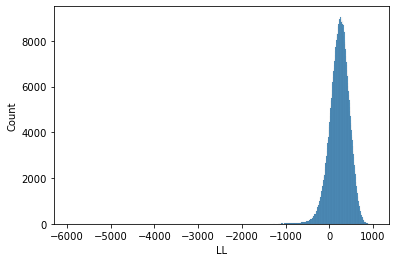

In [13]:
sns.histplot(evals_tbl[y2019].LL)

### Devide the data set into two groups

In [14]:
### Test of the module 'threshold_get()'
LL_pd = evals_tbl[y2019].LL
alpha = 0.999
q_left, q_right = threshold_get(LL_pd, alpha)
print(f'The left location is: {q_left}.')
print(f'The right location is: {q_right}.')

The left location is: -1548.1938535156248.
The right location is: 837.5729921875064.


In [15]:
### Test of 'outliers_preparing()' module
LL_pd = evals_tbl[y2019].LL
alpha = 0.999
left_outliers_indices, right_outliers_indices, normal_indices = outliers_preparing(LL_pd, alpha)

In [16]:
outliers_indices = np.concatenate((left_outliers_indices, right_outliers_indices), axis=0)

In [21]:
outliers_latents = latents_reduced[outliers_indices]

In [22]:
normal_latents = latents_reduced[normal_indices]

In [23]:
outliers_labels = np.ones(shape=(outliers_latents.shape[0]))
normal_labels = np.zeros(shape=(normal_latents.shape[0]))

In [46]:
normal_samples_indices = np.random.choice(normal_latents.shape[0], outliers_indices.shape[0] * 3)

In [47]:
normal_samples = normal_latents[normal_samples_indices]

In [49]:
normal_labels = np.zeros(outliers_indices.shape[0] * 3)

In [51]:
latents_labels = np.concatenate((normal_labels, outliers_labels), axis=0)
latents_red = np.concatenate((normal_samples, outliers_latents), axis=0)
assert latents_labels.shape[0] == latents_red.shape[0], "The result is inconsistent!"

Text(0.5, 1.0, 'Scatter plot of latents')

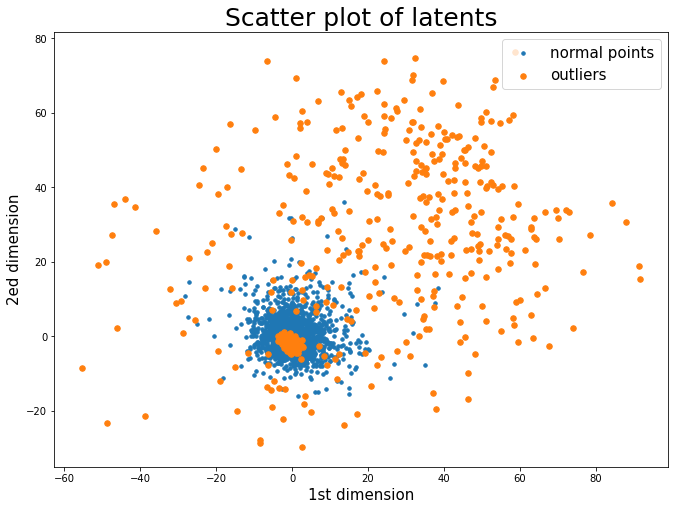

In [52]:
plt.figure(figsize=(11, 8))
plt.scatter(normal_samples[:, 0], normal_samples[:, 1],
            s=12, label='normal points')
plt.scatter(outliers_latents[:, 0], outliers_latents[:, 1],
            s=30, label='outliers')
plt.xlabel('1st dimension', fontsize=15)
plt.ylabel('2ed dimension', fontsize=15)
plt.legend(fontsize=15, loc=1)
plt.title('Scatter plot of latents', fontsize=25)

### Create the training and test data set

In [57]:
latents_samples = np.concatenate((normal_samples, outliers_latents))
labels_samples = np.concatenate((normal_labels, outliers_labels))
assert latents_samples.shape[0] == labels_samples.shape[0], 'The result is not right!'

In [65]:
from sklearn.model_selection import train_test_split

In [67]:
latents_train, latents_test, labels_train, labels_test = train_test_split(latents_samples, labels_samples, 
                                                                         test_size=0.2, random_state=0)

### Using the KNN to study the latents

In [58]:
n_neighbors = 2

In [59]:
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')

In [60]:
clf.fit(latents_samples[:, :2], labels_samples)

KNeighborsClassifier(n_neighbors=2)

In [61]:
h = 1
x_min, x_max = latents_samples[:, 0].min() - 1, latents_samples[:, 0].max() + 1
y_min, y_max = latents_samples[:, 1].min() - 1, latents_samples[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

In [62]:
normal_labels_string = np.array(['normal'] * normal_samples.shape[0])
outliers_labels_string = np.array(['outlier'] * outliers_latents.shape[0])
latents_labels_string = np.concatenate((normal_labels_string, outliers_labels_string))

In [63]:
from matplotlib.colors import ListedColormap

Text(0, 0.5, 'second dimension of the reduced latents')

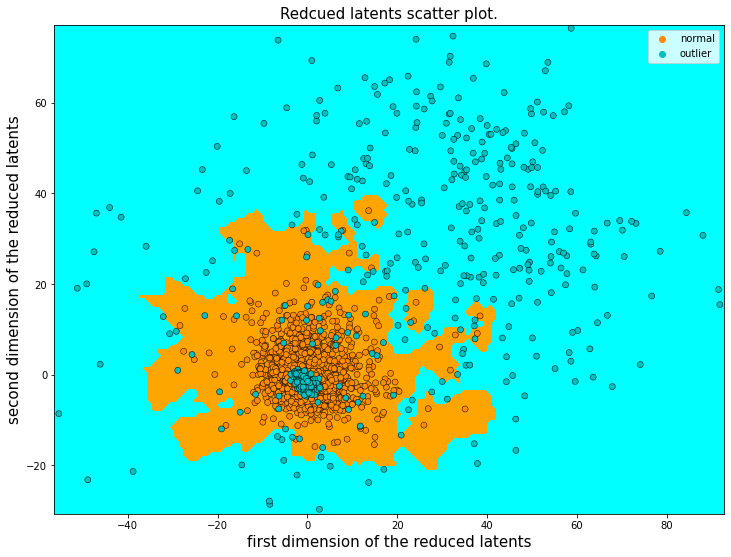

In [64]:
cmap_light = ListedColormap(['orange', 'cyan'])
cmap_bold = ['darkorange', 'c']
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12, 9))
plt.contourf(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(x=latents_red[:, 0], y=latents_red[:, 1], hue=latents_labels_string,
                palette=cmap_bold, alpha=1.0, edgecolor="black")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Redcued latents scatter plot.', fontsize=15)
plt.xlabel('first dimension of the reduced latents', fontsize=15)
plt.ylabel('second dimension of the reduced latents', fontsize=15)

----------------------------------------------------------------------------------------------------------

### Do prediction with KNN

In [78]:
n_neighbors = 2
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
clf.fit(latents_train, labels_train)

KNeighborsClassifier(n_neighbors=2)

In [79]:
labels_predict = clf.predict(latents_test)

In [80]:
accuracy_predict = np.mean(labels_predict == labels_test)

In [82]:
accuracy_predict

0.5016611295681063

In [83]:
left_outliers_indices.shape

(376,)

In [97]:
outliers_valid = outliers_indices[:10]
normal_valid = normal_indices[:10]

In [115]:
outliers_valid

array([  893,  7390,  8209,  9384, 13545, 18956, 19151, 19988, 21454,
       22501])

In [103]:
outliers_pred = clf.predict(latents_reduced[outliers_valid])

In [105]:
normal_pred = clf.predict(latents_reduced[normal_valid])

### Show the outliers cutouts

In [122]:
cutout_M_outliers_list = [evals_tbl.iloc[index] for index in outliers_valid]

In [125]:
img_modis_outliers_list = [modis_io.grab_image(cutout_M) for cutout_M in cutout_M_outliers_list]

In [124]:
pal, cm = plotting.load_palette()

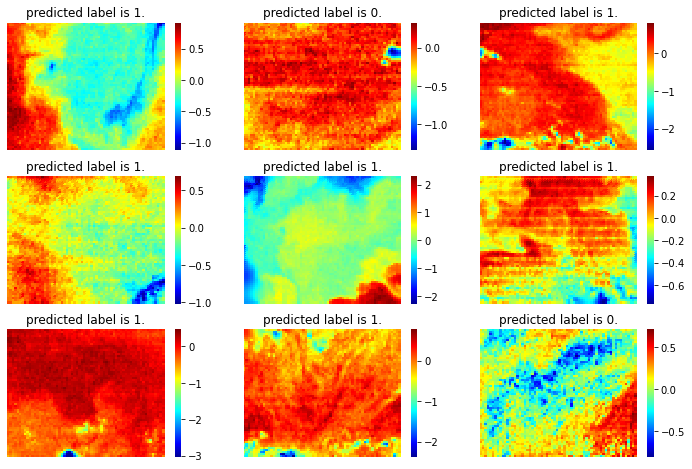

In [126]:
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    sns.heatmap(img_modis_outliers_list[i], xticklabels=[], yticklabels=[], cmap=cm, 
                 cbar=True)
    plt.title(f'predicted label is {int(outliers_pred[i])}.')

In [127]:
cutout_M_normal_list = [evals_tbl.iloc[index] for index in normal_valid]

In [128]:
img_modis_normal_list = [modis_io.grab_image(cutout_M) for cutout_M in cutout_M_normal_list]

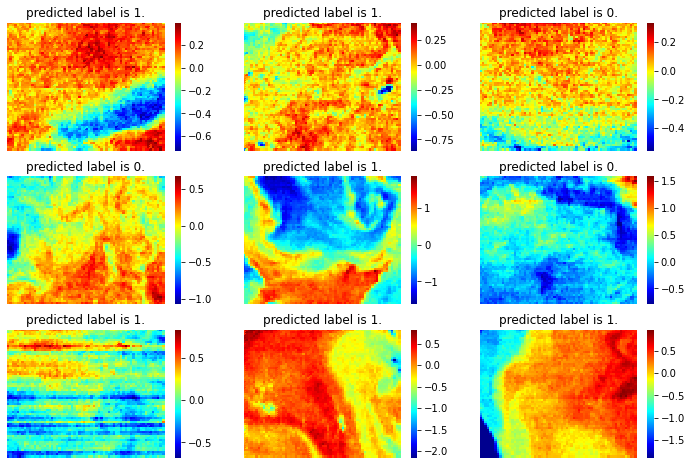

In [129]:
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    sns.heatmap(img_modis_normal_list[i], xticklabels=[], yticklabels=[], cmap=cm, 
                 cbar=True)
    plt.title(f'predicted label is {int(normal_pred[i])}.')